In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from auxiliar_func import preprocessing
from plot_func import *

In [2]:
df = pd.read_csv('Census-Income-KDD.csv')
target = 'income_50k'
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

In [3]:
df_train_pre = preprocessing(df_train)
df_test_pre = preprocessing(df_test)

# generate binary values of all categorical data using get_dummies
# keep the same columns in train and test
df_train_pre = pd.get_dummies(df_train_pre)
df_test_pre = pd.get_dummies(df_test_pre)
df_train_pre, df_test_pre = df_train_pre.align(df_test_pre, join='left', axis=1, fill_value=0)

array([[<Axes: title={'center': 'wage_per_hour'}>,
        <Axes: title={'center': 'capital_gains'}>,
        <Axes: title={'center': 'capital_losses'}>],
       [<Axes: title={'center': 'stock_dividends'}>,
        <Axes: title={'center': 'num_emp'}>,
        <Axes: title={'center': 'weeks_worked'}>],
       [<Axes: title={'center': 'income_50k'}>, <Axes: >, <Axes: >]],
      dtype=object)

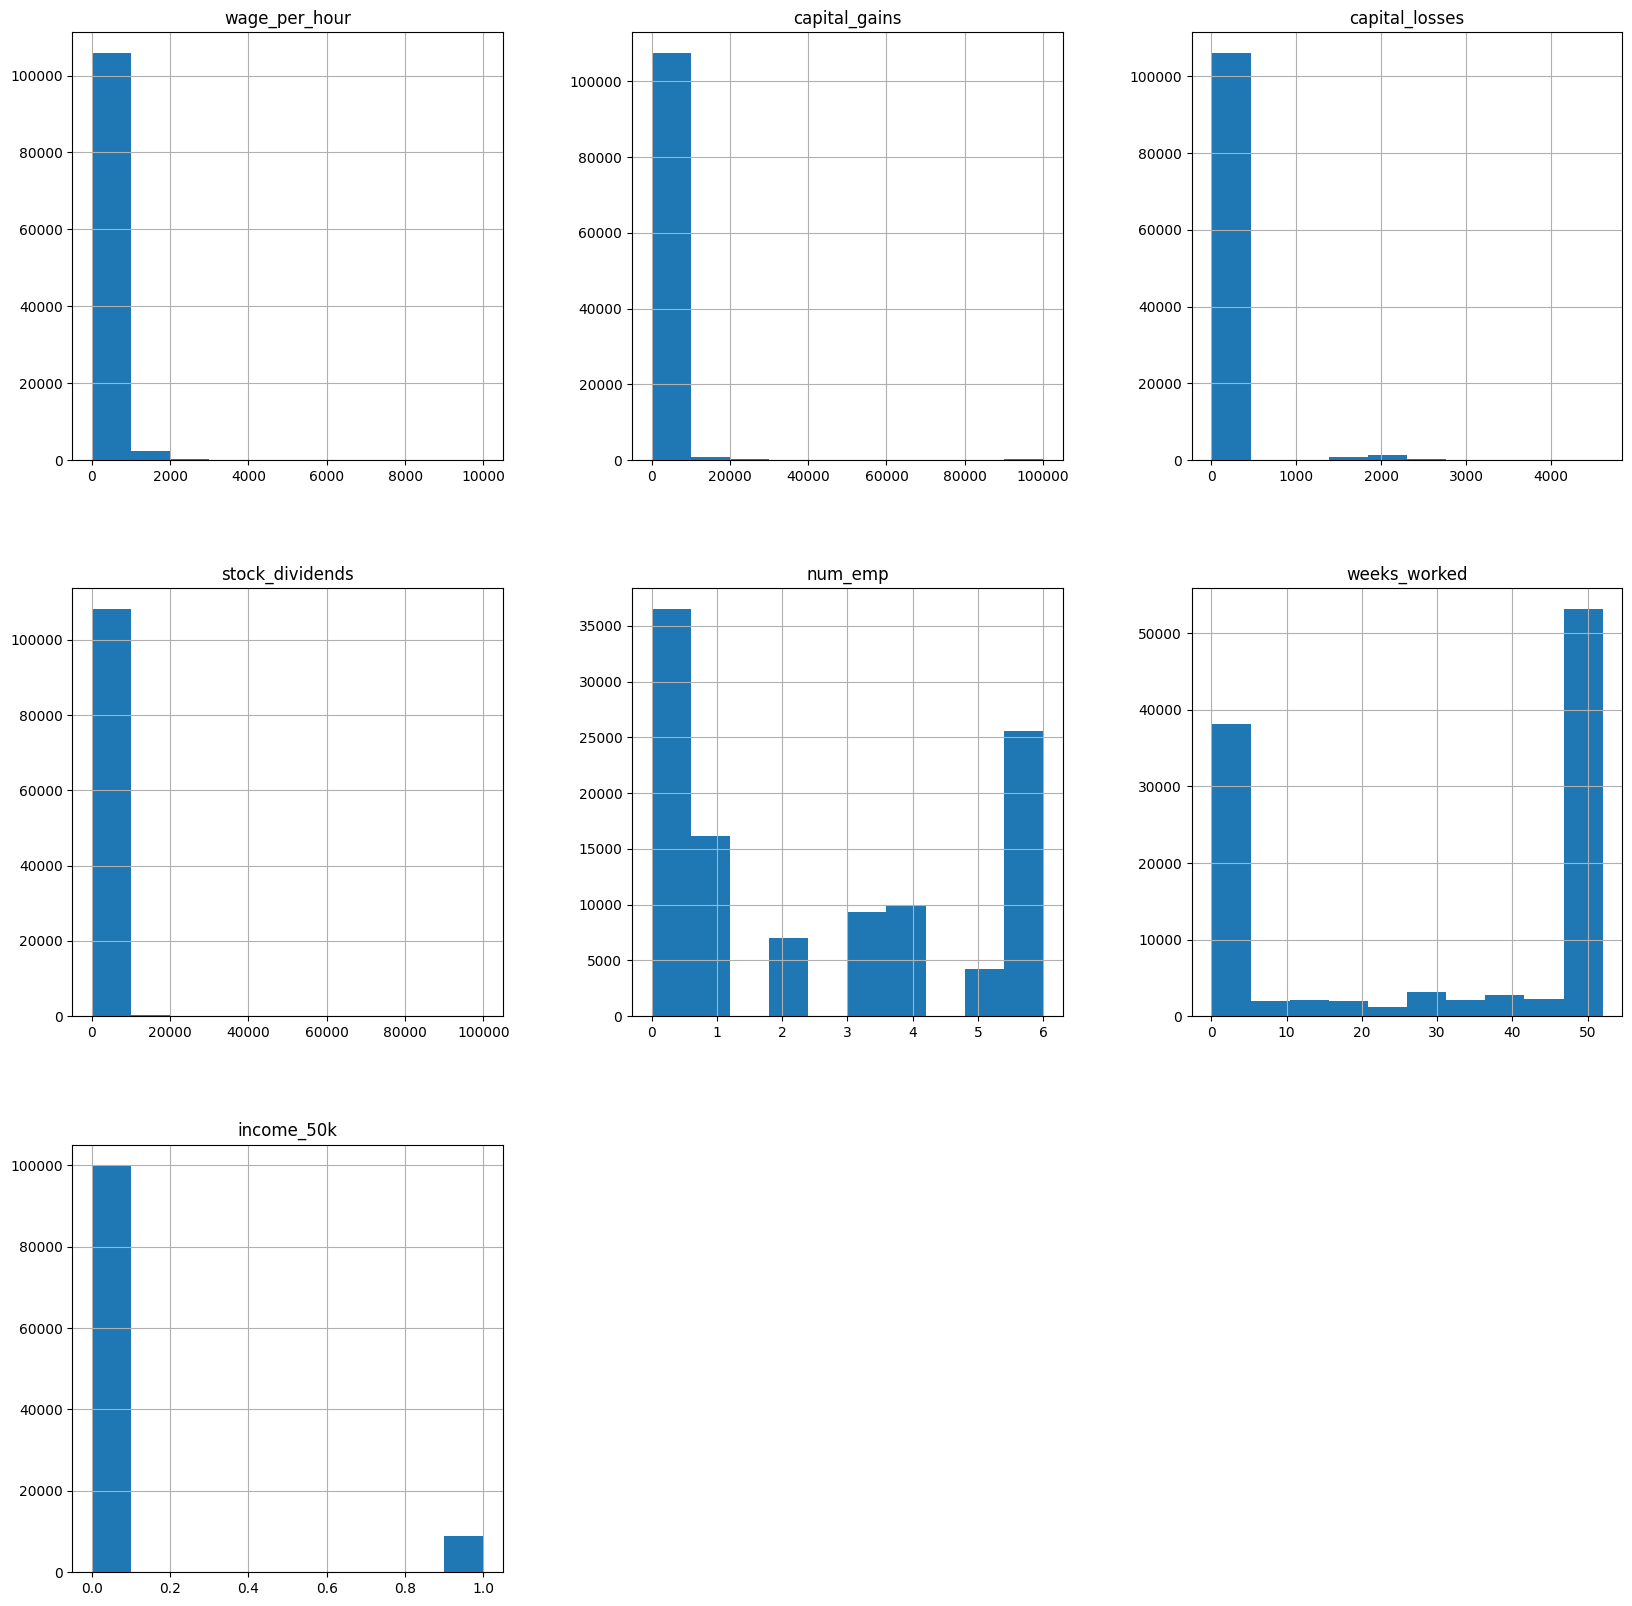

In [4]:
# plot the numerical variables of the train set
df_train_pre.hist(figsize=(20, 20))

In [4]:
df_train.shape, df_test.shape

((108859, 483), (48323, 483))

## Adjusting a logistic regression model

In [5]:
X_train, y_train = df_train.drop(target, axis=1), df_train[target]
X_test, y_test = df_test.drop(target, axis=1), df_test[target]

# adjust a logistic regression model to the data
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

C:\Users\joels\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Accuracy metrics:

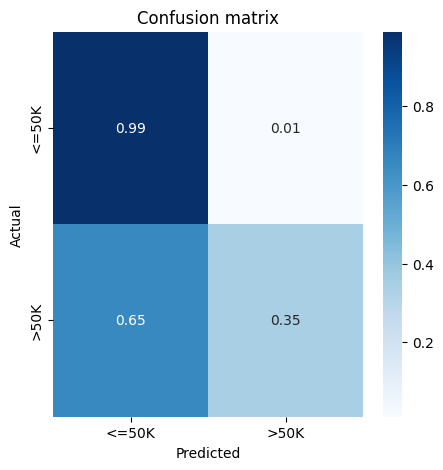

In [9]:
print('Accuracy score: ', accuracy_score(y_test, y_pred))
plot_conf_matrix(y_test, y_pred)